# Getting your hands dirty with LDA (Using the Foursquare API)

First things first, we want to develop a classifier that can detect if a user comment is misapplied to the venue. Think of all the times you've gone to an Amazon item and saw reviews that looked like the image below, "Used but in very good condition", "fast shipping" are these relevant to a product review? Or are they more appropriate for seller reviews? 

We're going to see if we can develop a comment classifier to detect which kinds of comments may be more appropriate for which venue type, and thus provide some indication on the "appropriateness" of the comment that can be used for further review, thus (we hope), improving the overall quality of Foursquare as a reviews platform

How do we plan on doing this? First, this lab will finally utilize a multi-class target. In this case, our goal will be to link comments we've extracted from Foursquare to store category type. 

As an example: "This place got me drunk" would be a comment you'd expect to see for a store category "bar" 
Yet, "I want to have my wedding here" is definitely not a comment you'd expect to see at a "bar" category (lest you live in Boston), more likely you'd see such a category associated with a park, or other such venue. 

The motivation for this exercise came from Amazon. Notice in the picture below, you see some comments that are speaking about the "condition" of the DVD and not the quality of the movie. These are an example of misapplied comments. I'm not promising our classifier will be this exact, but what we'll be doing is a big step in that direction. Excited? Good! Let's go!


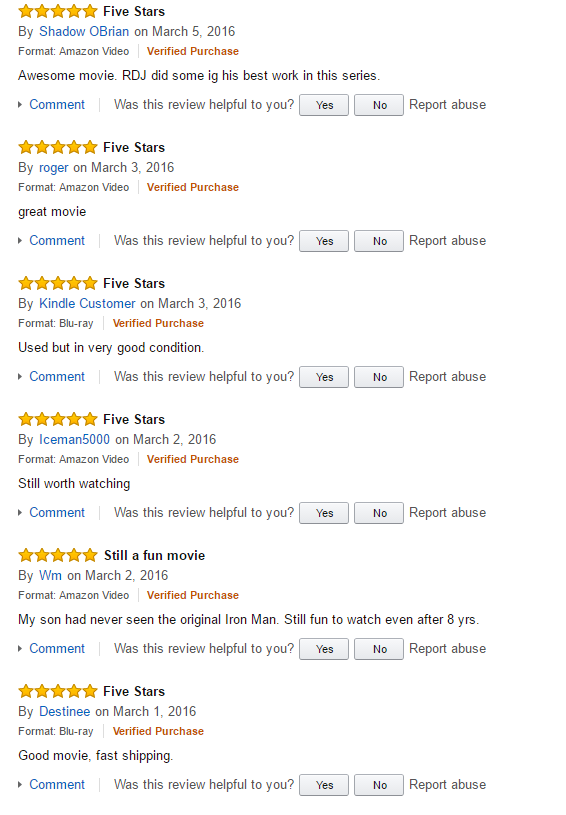

In [1]:
from IPython.display import Image
Image('/home/useraj/Documents/DSI-SYD-1/classes/week-08/3.4-lab/assets/amazon_image.png')

Use the previously built table-creator on a few categories of Foursquare venues. 

Find the category list code in the following page: https://developer.foursquare.com/categorytree

In [4]:
import foursquare
import json
import pandas as pd
import unicodedata

#ACCESS_TOKEN = ""
#client = foursquare.Foursquare(access_token=ACCESS_TOKEN)

CLIENT_ID = 'YU0GZL10NTN4C4OJ5RIFEVSZXZHSHJNT5D0BIE4MQ5MVKRPL'
CLIENT_SECRET = 'JVHGANJF203WEN3X0MOJJ2DQRKJFNX1TL2H0SRYWMNQIHKOJ'
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)


Load up the data we used previously, and use your scraper code to build your Foursquare table. We're going to do something a little different here. First, go into the category list https://developer.foursquare.com/categorytree and a category that will give you an at least 4 - 6 different store categories. You can experiment by inputting the categoryid into the starting list generator and then running the scraper code, then 'eye-balling' the store category section to see there are at least 4 - 6 different categories. 

If the category you selected does not have enough categories, you may have to either pick another, pull in multiple categories or merge.


In [12]:
def city_venues(city, catID):
    venues = pd.DataFrame()
    venues_list = client.venues.search(params={'near': city, 'radius':'3000', 'categoryId': catID})
    for i in range(len(venues_list['venues'])):
        ven_id = venues_list['venues'][i]['id'].encode('ascii', 'ignore')
        ven = client.venues(ven_id)
        mini_df = pd.DataFrame()
        mini_df['Comments'] = map(lambda h: h['text'].encode('ascii', 'ignore'), ven['venue']['tips']['groups'][0]['items'])
        mini_df['Venue_Name'] = venues_list['venues'][i]['name'].encode('ascii', 'ignore')
        mini_df['Tip_Count'] = ven['venue']['stats']['tipCount']
        mini_df['User_Count'] = ven['venue']['stats']['usersCount']
        if (venues_list['venues'][i]['categories']) != []:
            mini_df['Category'] = venues_list['venues'][i]['categories'][0]['name'].encode('ascii', 'ignore')
        else:
            mini_df['Category'] = "No Category"
        venues = pd.concat([venues, mini_df])
    return venues.reset_index(drop=True)

table1 = city_venues('San Francisco, CA', '4d4b7104d754a06370d81259')
table2 = city_venues('San Mateo, CA', '4d4b7104d754a06370d81259')
table3 = city_venues('Oakland, CA', '4d4b7104d754a06370d81259')


In [19]:
big_table = pd.concat([table1, table2, table3])
big_table = big_table.drop_duplicates()
big_table = big_table.reset_index(drop=True)

# Constructing features using string parsing and elementary text mining

Create a normalizer function that will take the comments, lowercase all uppercase letters, split each comment into an array/list/vector of words, and remove stop words. 

In [20]:
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3            
import numpy as np

stopwords = nltk.corpus.stopwords.words('english')

Write a normalizing method, one that will convert all letters in a string into lower case, and remove stopwords. 

A helpful references: https://docs.python.org/2/library/re.html

In [41]:
def normalizer(x):
    words = re.split(r"[^A-Za-z]", x.strip())
    result = []
    for word in words:
        if word not in stopwords and word != '':
            result.append(word.lower())
    return " ".join(result)


Test out your normalizer on a comment to ensure it's working. 

In [42]:
normalizer(big_table.Comments[4])


'apparently this theater contains chemicals known state ca cause cancer birth defects reproductive harm'

Use the normalizer that you created to build a 'stripped' down comments array/vector/list (however you did it)

In [43]:
norm_comments = big_table.Comments.map(normalizer)


In [44]:
norm_comments

0       make point wander lobby upstairs it beautiful ...
1                                            see spamalot
2                   sketchy neighborhood diva dianah ross
3                                             mythbusters
4       apparently this theater contains chemicals kno...
5                                             check shows
6       go see young frankenstein note adult themes fu...
7       if previously purchased reusable sippy cups pa...
8         ask shnsf bring rentmusical rent th anniversary
9                                  i love place i need go
10                               that really nice theatre
11      wonderful person theater if get front row mezz...
12      the theatre really beautiful and show pipin aw...
13      you buy cups lids drink really fast get back s...
14      no sense getting minutes show time seating sta...
15                            great place date night dale
16        scary area park lot side theater get early spot
17            

Vectorize your feature set into a dense matrix representation using Countvectorizer from sklearn

A helpful reference: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False)
X = vectorizer.fit_transform(norm_comments)


# Performing the LDA

Construct your LDA with the pieces above by fitting the model to your feature set and target

In [48]:
big_table.head(3)

Comments               Venue_Name  \
0  Make it a point to wander up to the lobby upst...  SHN Golden Gate Theatre   
1                                       See Spamalot  SHN Golden Gate Theatre   
2      Sketchy neighborhood for the diva Dianah Ross  SHN Golden Gate Theatre   

   Tip_Count  User_Count Category  
0         23        3898  Theater  
1         23        3898  Theater  
2         23        3898  Theater

In [47]:
import scipy
X_dense = X.todense()


In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
target = np.asarray(big_table['Category'])

X_lda_sklearn = LDA(n_components = 2).fit_transform(X_dense, target)

print(X_lda_sklearn )

[[  5.92558162   3.6172835 ]
 [  5.94045482   3.59204999]
 [  5.94671299   3.60887702]
 ..., 
 [ 15.22505415   0.11196541]
 [ 15.23408252   0.13788377]
 [ 15.24524452   0.14123725]]


# Visualizing Results

Now print the LDA and at least a few of the categories on a 2-D discriminant chart. Do you think the method is seperating the categories very well? Should we tune it more? Would it be a good indicator of "inappropriate commenting"? 

In [56]:
big_table.Category.value_counts()

Movie Theater              98
Music Venue                88
Bar                        80
Multiplex                  60
Museum                     47
Concert Hall               40
Art Museum                 40
Historic Site              40
Indie Movie Theater        40
Nightclub                  40
General Entertainment      22
Theme Park                 21
Theater                    21
Pub                        20
Rock Club                  20
Church                     20
Cable Car                  20
Mini Golf                  20
Jazz Club                  20
Convention Center          20
Irish Pub                  20
Arcade                     20
Tapas Restaurant           20
Lounge                     20
Baseball Stadium           20
Coffee Shop                20
National Park              20
Dive Bar                   20
Restaurant                 20
New American Restaurant    20
Event Space                20
Farmers Market             20
Cocktail Bar               20
Monument /

In [7]:
import matplotlib.pyplot as plt

for c, i in zip("rgbcmykw", ['Liquor Store', 'Winery', 'Wings Joint', 'Seafood Restaurant', 'American Restaurant', 'Mexican Restaurant', 'Seafood Restaurant', 'Sports Bar']):
    plt.scatter(X_lda_sklearn[target == i, 0], X_lda_sklearn[target == i, 1], c=c)
    plt.legend()

plt.show()
